# Bibliotekos

In [2]:
from symbol import comparison

import pandas as pd
import numpy as np
import seaborn as sns
from nltk.chunk.named_entity import shape
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import spacy
from sklearn.ensemble import StackingClassifier

# Failo skaitymas

In [3]:

# Perskaitome failą
df = pd.read_csv("spam.csv", encoding="latin-1")

df = df.iloc[:, :2]  # pasirenkam tik pirmus du stulpelius
df.columns = ['label', 'text']  # pervadinam, jei reikia
df['text'] = df['text'].str.lower()

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [4]:
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

print(df.head())

   label                                               text
0      0  go until jurong point, crazy.. available only ...
1      0                      ok lar... joking wif u oni...
2      1  free entry in 2 a wkly comp to win fa cup fina...
3      0  u dun say so early hor... u c already then say...
4      0  nah i don't think he goes to usf, he lives aro...


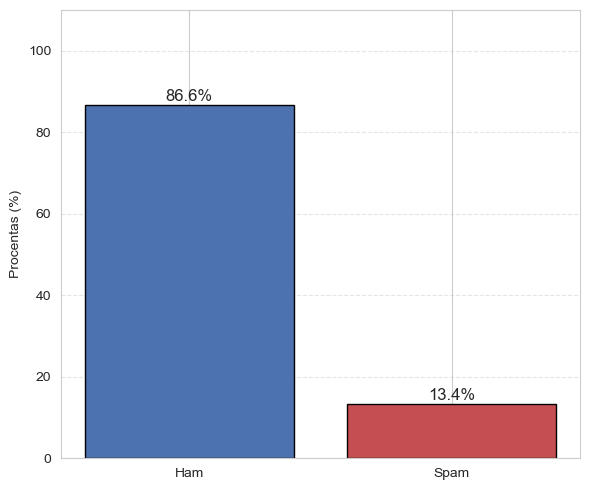

In [5]:
# Suskaičiuojame kiekvieną klasę
counts = df['label'].value_counts(normalize=True) * 100  # procentai

# Sukuriame bar plot
plt.figure(figsize=(6, 5))
plt.bar(['Ham', 'Spam'], counts, color=['#4C72B0', '#C44E52'], edgecolor='black')

# Pridedame procentus virš barų
for i, val in enumerate(counts):
    plt.text(i, val + 1, f'{val:.1f}%', ha='center', fontsize=12)

plt.ylabel('Procentas (%)')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

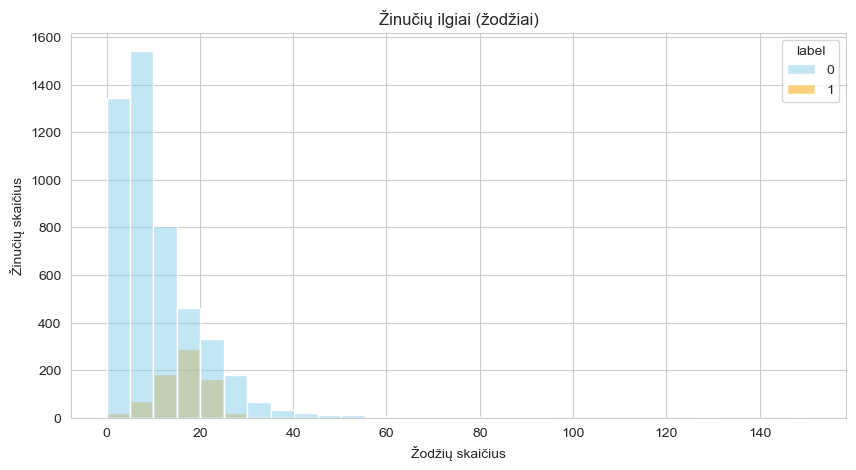

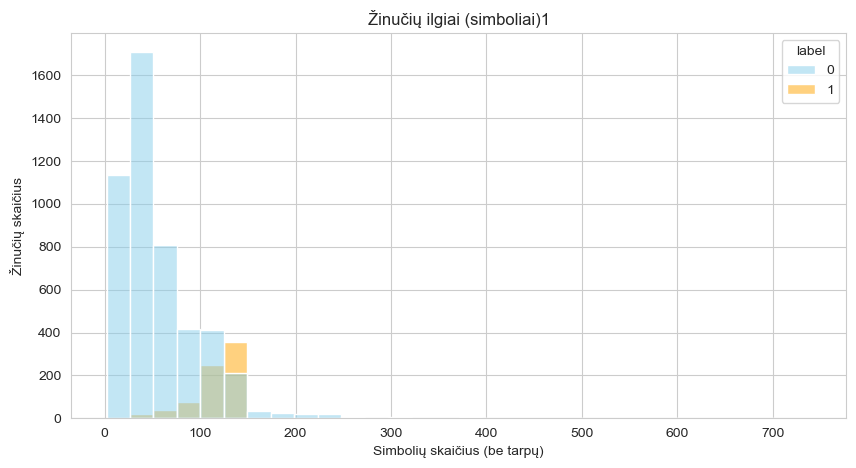

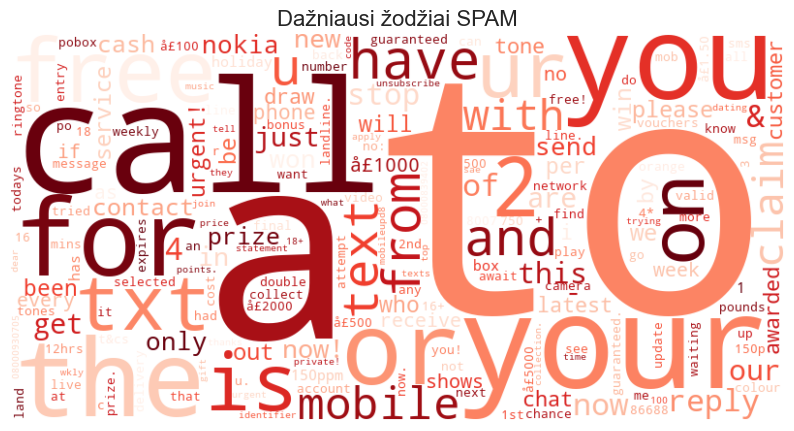

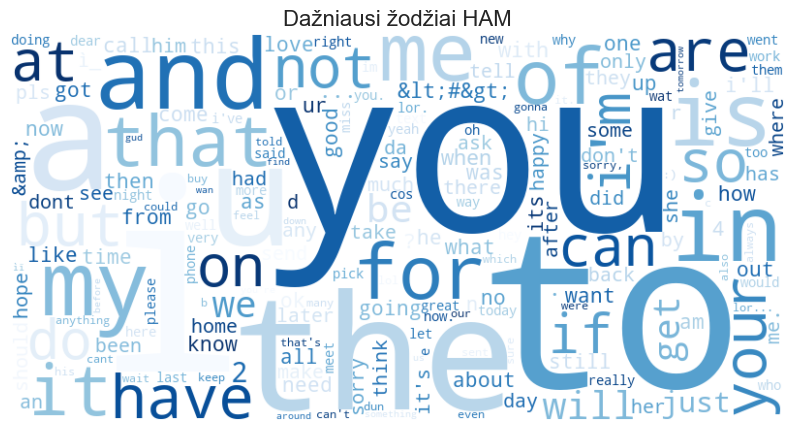

Top SPAM: [('to', 682), ('a', 373), ('call', 342), ('your', 263), ('you', 252), ('the', 204), ('for', 201), ('or', 188), ('free', 180), ('2', 169), ('is', 152), ('ur', 144), ('on', 141), ('txt', 136), ('have', 135), ('from', 127), ('and', 122), ('u', 117), ('text', 112), ('mobile', 109)]
Top HAM: [('i', 2172), ('you', 1665), ('to', 1544), ('the', 1113), ('a', 1046), ('u', 874), ('and', 845), ('in', 786), ('my', 741), ('is', 710), ('me', 584), ('of', 518), ('for', 496), ('that', 442), ('it', 440), ('have', 433), ('your', 413), ('but', 413), ('are', 405), ('so', 399)]


In [6]:
df['word_count'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isalpha()]))


df['char_count'] = df['text'].apply(lambda x: len(str(x).replace(" ", "")))

def plot_histograms(df, suffix=""):
    plt.figure(figsize=(10,5))
    sns.histplot(df, x='word_count', hue='label', bins=30, kde=False, palette={0:'skyblue',1:'orange'})
    plt.xlabel("Žodžių skaičius")
    plt.ylabel("Žinučių skaičius")
    plt.title(f"Žinučių ilgiai (žodžiai)")
    plt.show()

    plt.figure(figsize=(10,5))
    sns.histplot(df, x='char_count', hue='label', bins=30, kde=False, palette={0:'skyblue',1:'orange'})
    plt.xlabel("Simbolių skaičius (be tarpų)")
    plt.ylabel("Žinučių skaičius")
    plt.title(f"Žinučių ilgiai (simboliai)1")
    plt.show()

plot_histograms(df, "(original)")

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def plot_wordcloud(df, label, title):
    text = " ".join(df[df['label'] == label]['text'])

    word_freq = Counter(text.split())

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Reds' if label == 1 else 'Blues'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()


plot_wordcloud(df, 1, "Dažniausi žodžiai SPAM")
plot_wordcloud(df, 0, "Dažniausi žodžiai HAM")

def get_top_words(df, label, n=20):
    words = " ".join(df[df['label']==label]['text']).split()
    counter = Counter(words)
    return counter.most_common(n)

top_spam = get_top_words(df, 1)
top_ham = get_top_words(df, 0)
print("Top SPAM:", top_spam)
print("Top HAM:", top_ham)

In [7]:
# Sukuriame savo stop_words sąrašą
my_stop_words = {
    'the', 'a', 'an', 'and', 'or', 'in', 'on', 'of', 'to', 'for', 'is', 'are',
    'was', 'were', 'be', 'been', 'it', 'this', 'that', 'with', 'as', 'by', 'at',
    'from', 'about', 'into', 'up', 'out', 'so', 'if', 'then', 'but', 'you', 'your', 'have',
    'u', 'just'
}

def remove_stopwords(text):
    words = str(text).lower().split()
    filtered = [w for w in words if w not in my_stop_words]
    return " ".join(filtered)

# Sukuriame kopiją ir pritaikome funkciją
df_sw = df.copy()
df_sw['text'] = df_sw['text'].apply(remove_stopwords)


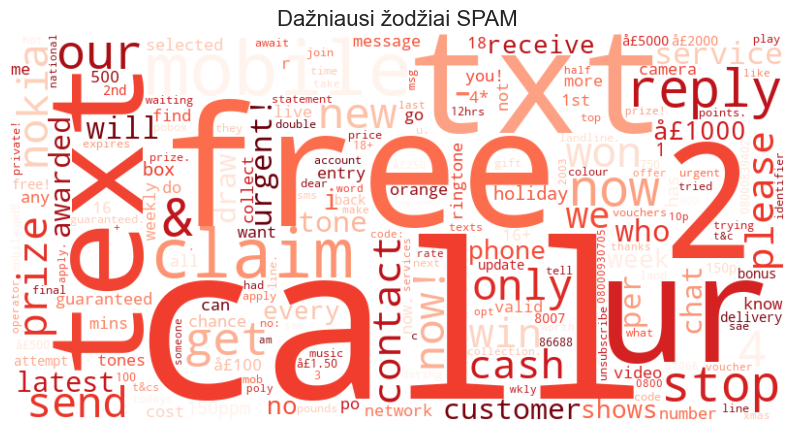

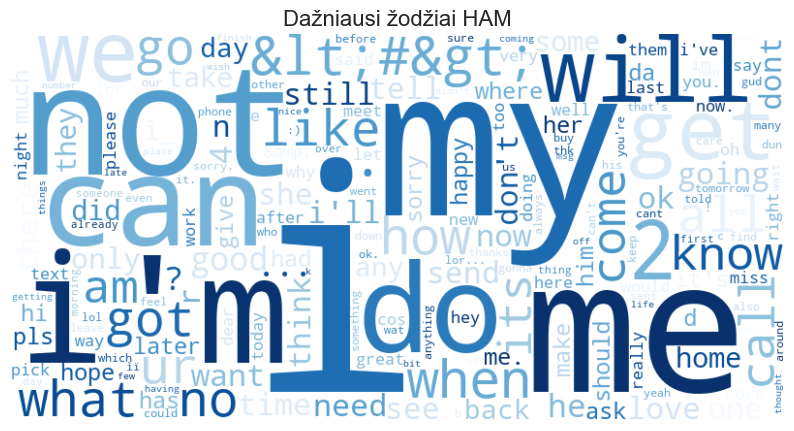

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def plot_wordcloud(df, label, title):
    text = " ".join(df[df['label'] == label]['text'])

    word_freq = Counter(text.split())

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Reds' if label == 1 else 'Blues'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()


plot_wordcloud(df_sw, 1, "Dažniausi žodžiai SPAM")
plot_wordcloud(df_sw, 0, "Dažniausi žodžiai HAM")


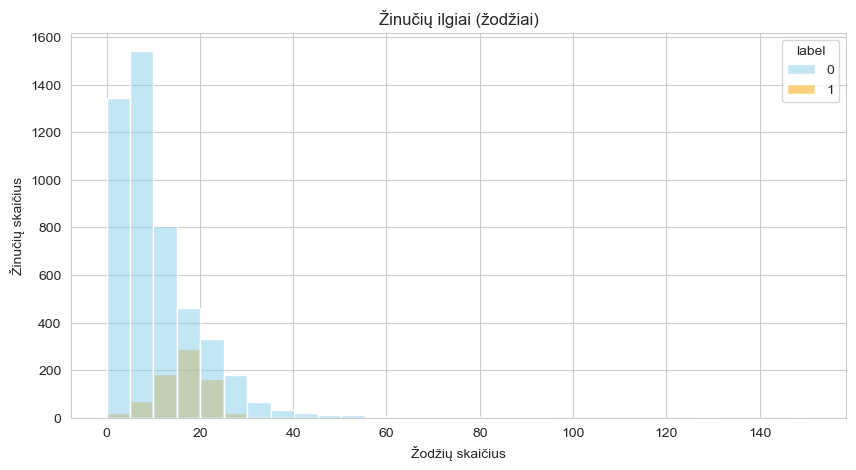

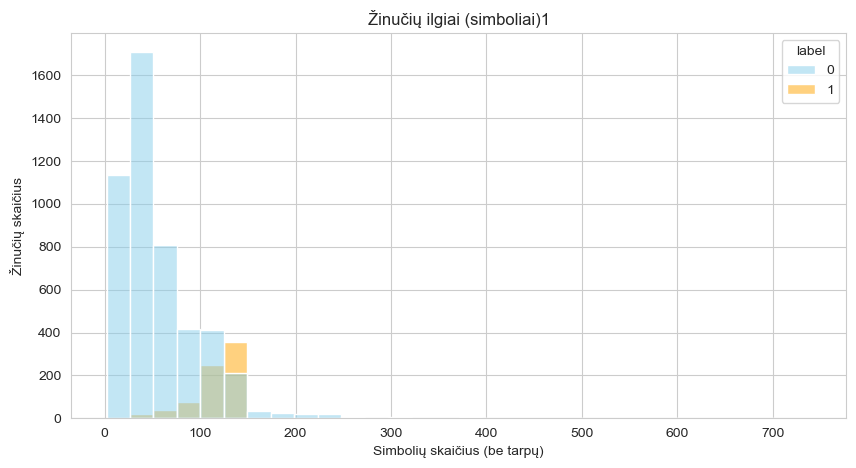

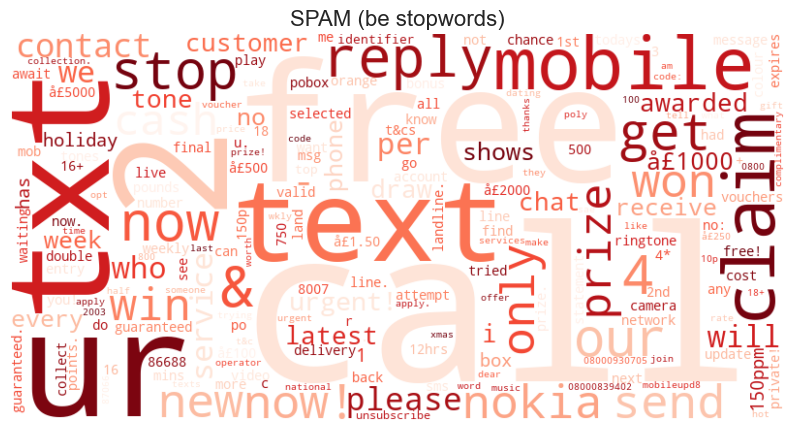

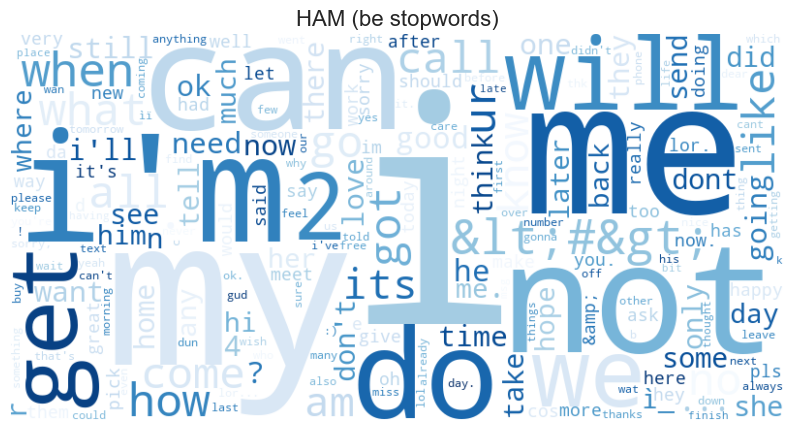

Top SPAM (be stopwords): [('call', 342), ('free', 180), ('2', 169), ('ur', 144), ('txt', 136), ('text', 112), ('mobile', 109), ('claim', 106), ('reply', 101), ('&', 98), ('now', 93), ('4', 93), ('stop', 89), ('our', 85), ('get', 82), ('now!', 70), ('new', 69), ('only', 66), ('send', 65), ('won', 64)]
Top HAM (be stopwords): [('i', 2172), ('my', 741), ('me', 584), ('not', 381), ("i'm", 369), ('can', 356), ('do', 342), ('will', 331), ('we', 297), ('get', 293), ('2', 284), ('&lt;#&gt;', 276), ('when', 270), ('how', 245), ('go', 235), ('ur', 235), ('what', 235), ('all', 231), ('got', 227), ('no', 225)]


In [9]:
plot_histograms(df_sw, "(be stopwords)")
plot_wordcloud(df_sw, 1, "SPAM (be stopwords)")
plot_wordcloud(df_sw, 0, "HAM (be stopwords)")

top_spam_sw = get_top_words(df_sw, 1)
top_ham_sw = get_top_words(df_sw, 0)
print("Top SPAM (be stopwords):", top_spam_sw)
print("Top HAM (be stopwords):", top_ham_sw)


# Vektorizavimas/mokymas


In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=5),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}
nlp = spacy.load("en_core_web_md")

def vectorize_text(df, method="bow", vectorizer=None):
    texts = df['text'].astype(str).tolist()

    if method == "bow":
        if vectorizer is None:
            vectorizer = CountVectorizer()
            X = vectorizer.fit_transform(texts)   # treniruojam + kuriam zodyna
        else:
            X = vectorizer.transform(texts)       # naudojam esama zodyna

    elif method == "tfidf":
        if vectorizer is None:
            vectorizer = TfidfVectorizer()
            X = vectorizer.fit_transform(texts)
        else:
            X = vectorizer.transform(texts)

    elif method == "spacy_w2v":
        # spacy nereikia vectorizer
        X = np.array([nlp(t).vector for t in texts])
        vectorizer = None
    else:
        raise ValueError("Nežinomas metodas")

    return X, vectorizer

def train_and_evaluate(models, X_train, X_test, y_train, y_test, title=""):
    results = []
    print(f"\n=== {title} ===")
    for name, model in models.items():
        print(f"🔹 Treniruojamas: {name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((name, acc))
        print(f"✅ Tikslumas: {acc:.4f}")
        print(classification_report(y_test, y_pred, digits=3))
        print("-"*50)
    return pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)

def plot_results(df, title=""):
    df = df.sort_values(by="Accuracy", ascending=True)
    plt.figure(figsize=(10,6))
    plt.barh(df["Model"], df["Accuracy"], color='skyblue')
    for i, v in enumerate(df["Accuracy"]):
        plt.text(v + 0.002, i, f"{v:.3f}", va='center')
    plt.xlabel("Tikslumas")
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

# Train/Test padalinimas bei mokymas



### Vektorizacija: BOW ###

=== BOW - original ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9830
              precision    recall  f1-score   support

           0      0.984     0.997     0.990       978
           1      0.976     0.883     0.927       137

    accuracy                          0.983      1115
   macro avg      0.980     0.940     0.959      1115
weighted avg      0.983     0.983     0.983      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9883
              precision    recall  f1-score   support

           0      0.988     0.999     0.993       978
           1      0.992     0.912     0.951       137

    accuracy                          0.988      1115
   macro avg      0.990     0.956     0.972      1115
weighted avg      0.988     0.988     0.988      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest


C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


✅ Tikslumas: 0.9776
              precision    recall  f1-score   support

           0      0.977     0.998     0.987       978
           1      0.983     0.832     0.901       137

    accuracy                          0.978      1115
   macro avg      0.980     0.915     0.944      1115
weighted avg      0.978     0.978     0.977      1115

--------------------------------------------------
🔹 Treniruojamas: KNN
✅ Tikslumas: 0.9327
              precision    recall  f1-score   support

           0      0.929     1.000     0.963       978
           1      1.000     0.453     0.623       137

    accuracy                          0.933      1115
   macro avg      0.964     0.726     0.793      1115
weighted avg      0.938     0.933     0.921      1115

--------------------------------------------------


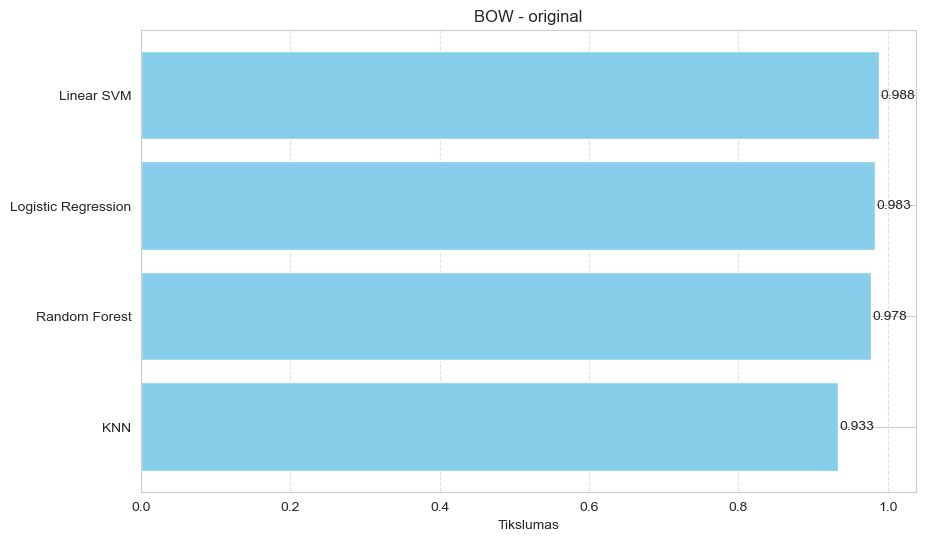


=== BOW - no_stopwords ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9839
              precision    recall  f1-score   support

           0      0.983     0.999     0.991       978
           1      0.992     0.876     0.930       137

    accuracy                          0.984      1115
   macro avg      0.987     0.937     0.961      1115
weighted avg      0.984     0.984     0.983      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9892
              precision    recall  f1-score   support

           0      0.988     1.000     0.994       978
           1      1.000     0.912     0.954       137

    accuracy                          0.989      1115
   macro avg      0.994     0.956     0.974      1115
weighted avg      0.989     0.989     0.989      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest


C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


✅ Tikslumas: 0.9803
              precision    recall  f1-score   support

           0      0.980     0.998     0.989       978
           1      0.983     0.854     0.914       137

    accuracy                          0.980      1115
   macro avg      0.982     0.926     0.951      1115
weighted avg      0.980     0.980     0.980      1115

--------------------------------------------------
🔹 Treniruojamas: KNN
✅ Tikslumas: 0.9238
              precision    recall  f1-score   support

           0      0.920     1.000     0.958       978
           1      1.000     0.380     0.550       137

    accuracy                          0.924      1115
   macro avg      0.960     0.690     0.754      1115
weighted avg      0.930     0.924     0.908      1115

--------------------------------------------------


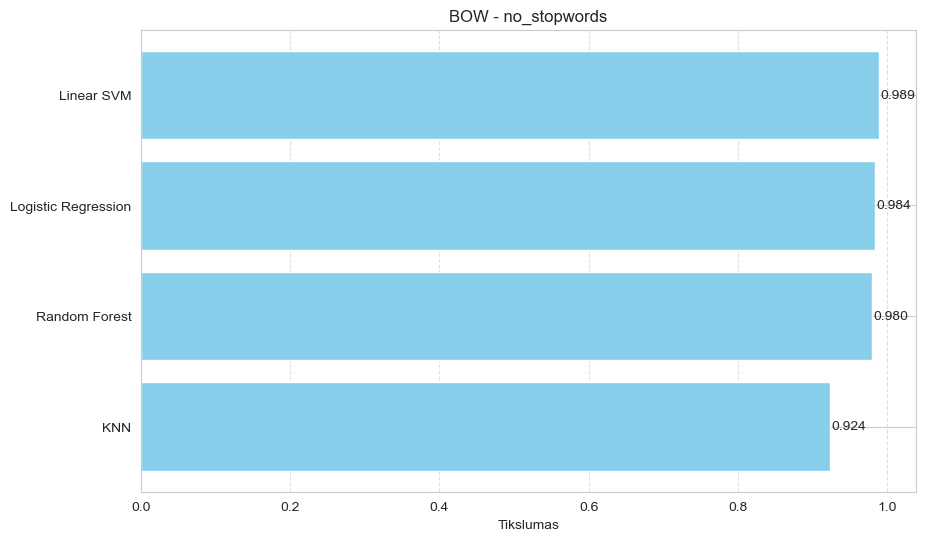



### Vektorizacija: TFIDF ###

=== TFIDF - original ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9677
              precision    recall  f1-score   support

           0      0.964     1.000     0.982       978
           1      1.000     0.737     0.849       137

    accuracy                          0.968      1115
   macro avg      0.982     0.869     0.915      1115
weighted avg      0.969     0.968     0.966      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9865
              precision    recall  f1-score   support

           0      0.985     1.000     0.992       978
           1      1.000     0.891     0.942       137

    accuracy                          0.987      1115
   macro avg      0.992     0.945     0.967      1115
weighted avg      0.987     0.987     0.986      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest


C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


✅ Tikslumas: 0.9803
              precision    recall  f1-score   support

           0      0.980     0.998     0.989       978
           1      0.983     0.854     0.914       137

    accuracy                          0.980      1115
   macro avg      0.982     0.926     0.951      1115
weighted avg      0.980     0.980     0.980      1115

--------------------------------------------------
🔹 Treniruojamas: KNN
✅ Tikslumas: 0.9184
              precision    recall  f1-score   support

           0      0.915     1.000     0.956       978
           1      1.000     0.336     0.503       137

    accuracy                          0.918      1115
   macro avg      0.957     0.668     0.729      1115
weighted avg      0.925     0.918     0.900      1115

--------------------------------------------------


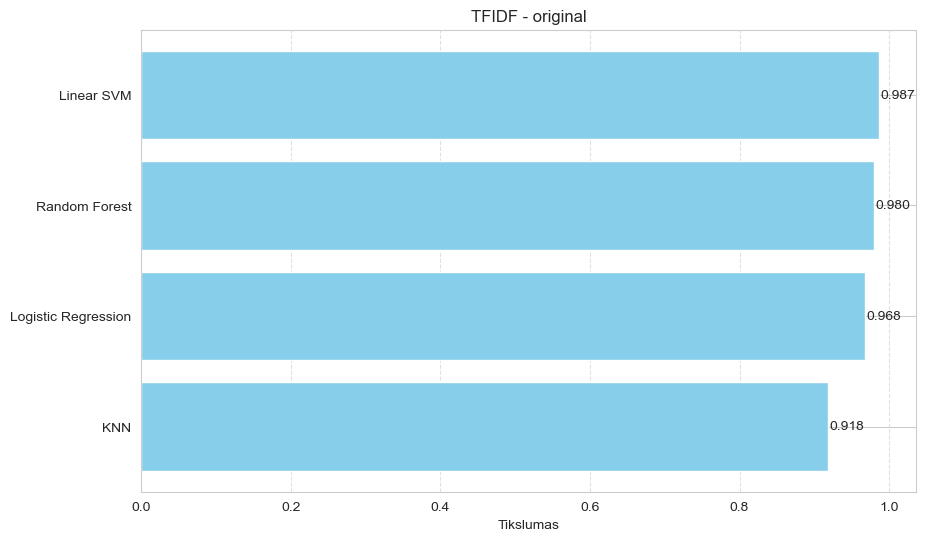


=== TFIDF - no_stopwords ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9668
              precision    recall  f1-score   support

           0      0.964     1.000     0.981       978
           1      1.000     0.730     0.844       137

    accuracy                          0.967      1115
   macro avg      0.982     0.865     0.913      1115
weighted avg      0.968     0.967     0.965      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9857
              precision    recall  f1-score   support

           0      0.984     1.000     0.992       978
           1      1.000     0.883     0.938       137

    accuracy                          0.986      1115
   macro avg      0.992     0.942     0.965      1115
weighted avg      0.986     0.986     0.985      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest


C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


✅ Tikslumas: 0.9803
              precision    recall  f1-score   support

           0      0.980     0.998     0.989       978
           1      0.983     0.854     0.914       137

    accuracy                          0.980      1115
   macro avg      0.982     0.926     0.951      1115
weighted avg      0.980     0.980     0.980      1115

--------------------------------------------------
🔹 Treniruojamas: KNN
✅ Tikslumas: 0.9148
              precision    recall  f1-score   support

           0      0.911     1.000     0.954       978
           1      1.000     0.307     0.469       137

    accuracy                          0.915      1115
   macro avg      0.956     0.653     0.711      1115
weighted avg      0.922     0.915     0.894      1115

--------------------------------------------------


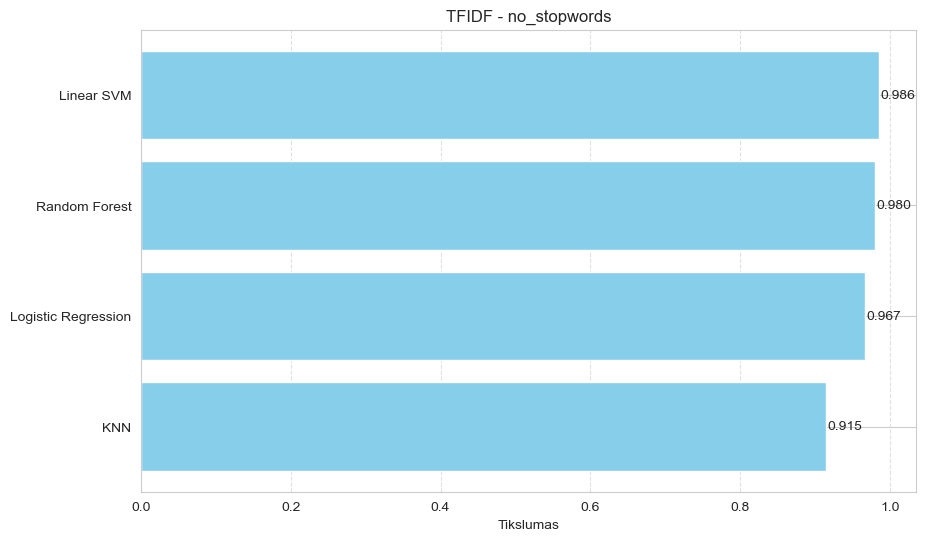



### Vektorizacija: SPACY_W2V ###

=== SPACY_W2V - original ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9668
              precision    recall  f1-score   support

           0      0.983     0.980     0.981       978
           1      0.857     0.876     0.866       137

    accuracy                          0.967      1115
   macro avg      0.920     0.928     0.924      1115
weighted avg      0.967     0.967     0.967      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM


C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


✅ Tikslumas: 0.9471
              precision    recall  f1-score   support

           0      0.986     0.953     0.969       978
           1      0.729     0.905     0.808       137

    accuracy                          0.947      1115
   macro avg      0.858     0.929     0.889      1115
weighted avg      0.955     0.947     0.949      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9749
              precision    recall  f1-score   support

           0      0.974     0.998     0.986       978
           1      0.982     0.810     0.888       137

    accuracy                          0.975      1115
   macro avg      0.978     0.904     0.937      1115
weighted avg      0.975     0.975     0.974      1115

--------------------------------------------------
🔹 Treniruojamas: KNN
✅ Tikslumas: 0.9498
              precision    recall  f1-score   support

           0      0.987     0.955     0.971       978
           1      0.740

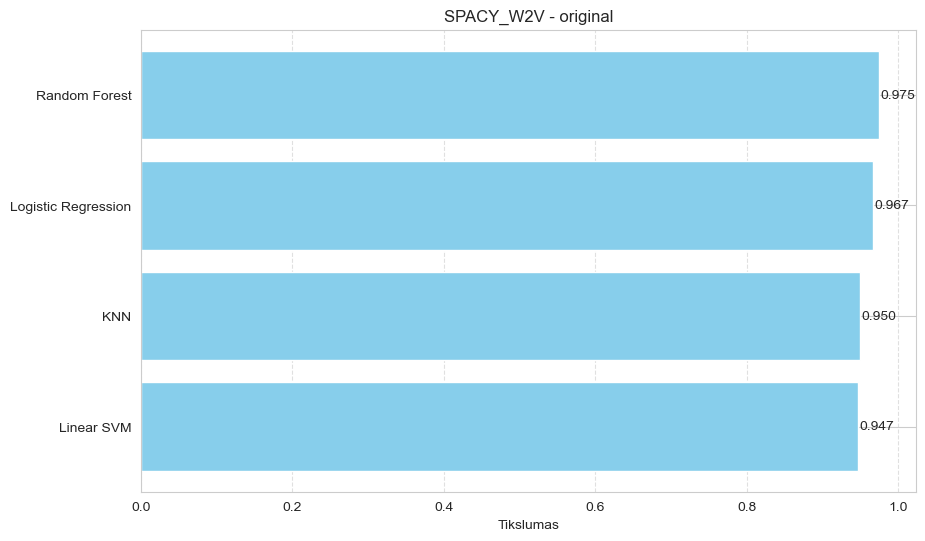


=== SPACY_W2V - no_stopwords ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9668
              precision    recall  f1-score   support

           0      0.984     0.979     0.981       978
           1      0.852     0.883     0.867       137

    accuracy                          0.967      1115
   macro avg      0.918     0.931     0.924      1115
weighted avg      0.967     0.967     0.967      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM


C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


✅ Tikslumas: 0.9561
              precision    recall  f1-score   support

           0      0.985     0.964     0.975       978
           1      0.778     0.898     0.834       137

    accuracy                          0.956      1115
   macro avg      0.882     0.931     0.904      1115
weighted avg      0.960     0.956     0.957      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9722
              precision    recall  f1-score   support

           0      0.973     0.996     0.984       978
           1      0.965     0.803     0.876       137

    accuracy                          0.972      1115
   macro avg      0.969     0.899     0.930      1115
weighted avg      0.972     0.972     0.971      1115

--------------------------------------------------
🔹 Treniruojamas: KNN
✅ Tikslumas: 0.9525
              precision    recall  f1-score   support

           0      0.989     0.956     0.972       978
           1      0.747

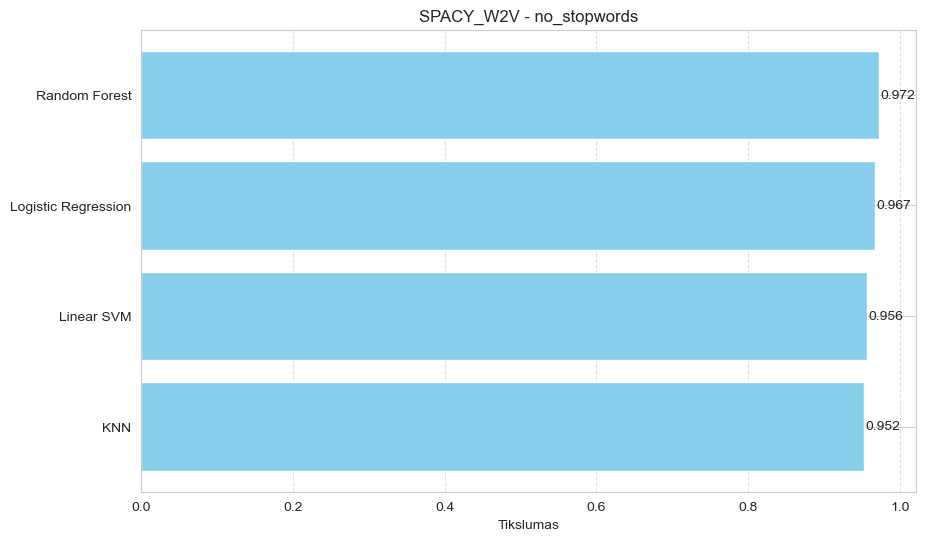

In [11]:
y = df['label'].values
results_all = {}
for method in ["bow", "tfidf", "spacy_w2v"]:
    print(f"\n\n### Vektorizacija: {method.upper()} ###")
    for data, label in [(df, "original"), (df_sw, "no_stopwords")]:
        X, vectorizer = vectorize_text(data, method)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
        results = train_and_evaluate(models, X_train, X_test, y_train, y_test, title=f"{method.upper()} - {label}")
        results_all[f"{method}_{label}"] = results
        plot_results(results, title=f"{method.upper()} - {label}")

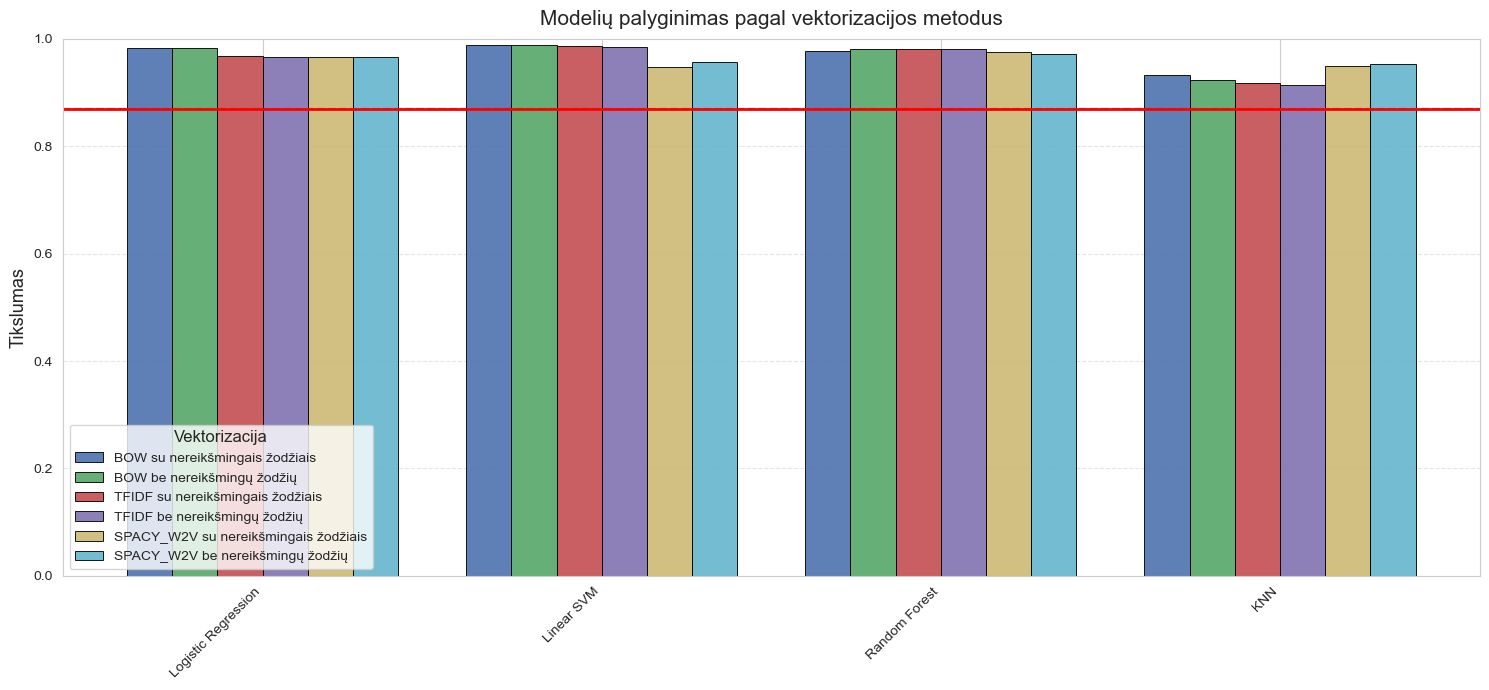

In [12]:
comparison_df = pd.DataFrame({"Model": list(models.keys())})
for key, df_res in results_all.items():
    comparison_df = comparison_df.merge(df_res, on="Model", how="left", suffixes=("", f"_{key}"))

comparison_df.columns = ["Model"] + [f"Accuracy_{k}" for k in results_all.keys()]

# Užtikriname, kad stulpeliai būtų float
for col in comparison_df.columns[1:]:
    comparison_df[col] = comparison_df[col].astype(float)

x = np.arange(len(comparison_df))
n_methods = len(comparison_df.columns) - 1
width = 0.8 / n_methods

# Gražesnė spalvų paletė
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974", "#64B5CD"]

# Friendly legendos pavadinimai
friendly_labels = {
    "BOW_ORIGINAL": "BOW su nereikšmingais žodžiais",
    "BOW_NO_STOPWORDS": "BOW be nereikšmingų žodžių",
    "TFIDF_ORIGINAL": "TFIDF su nereikšmingais žodžiais",
    "TFIDF_NO_STOPWORDS": "TFIDF be nereikšmingų žodžių",
    "SPACY_W2V_ORIGINAL": "SPACY_W2V su nereikšmingais žodžiais",
    "SPACY_W2V_NO_STOPWORDS": "SPACY_W2V be nereikšmingų žodžių"
}

x = np.arange(len(comparison_df))
n_methods = len(comparison_df.columns) - 1
width = 0.8 / n_methods

plt.figure(figsize=(15, 7))

for i, col in enumerate(comparison_df.columns[1:]):
    # Pašaliname "Accuracy_" prefix
    key_name = col.replace("Accuracy_", "")
    # Tikrai sutapimas su friendly_labels
    label = friendly_labels.get(key_name.upper(), key_name)

    plt.bar(
        x + i * width - (width * (n_methods - 1) / 2),
        comparison_df[col].astype(float),
        width,
        label=label,
        alpha=0.9,
        edgecolor="black",
        linewidth=0.7,
        color=colors[i % len(colors)]
    )

plt.xticks(x, comparison_df["Model"], rotation=45, ha='right')
plt.axhline(0.87, color='red', linewidth=2)

plt.ylabel("Tikslumas", fontsize=13)
plt.title("Modelių palyginimas pagal vektorizacijos metodus", fontsize=15, pad=10)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.axhline(y=0.87, color="red", linestyle="--", linewidth=1.5)
plt.legend(title="Vektorizacija", title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()

# Ensemble

In [13]:
base_models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=5)),
    ('Linear SVM', LinearSVC(random_state=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=5))
]

In [14]:
X, vectorizer = vectorize_text(df_sw, 'bow')
y = df_sw['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [15]:
meta_model_svc = LogisticRegression(max_iter=1000, random_state=5)

stack_svc = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model_svc,
    passthrough=True,
    cv=5
)

stack_svc.fit(X_train, y_train)
y_pred = stack_svc.predict(X_test)

print("✅ Stacking tikslumas:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nik

✅ Stacking tikslumas: 0.9910313901345291
              precision    recall  f1-score   support

           0      0.992     0.998     0.995       978
           1      0.985     0.942     0.963       137

    accuracy                          0.991      1115
   macro avg      0.988     0.970     0.979      1115
weighted avg      0.991     0.991     0.991      1115



In [16]:
probas = stack_svc.predict_proba(X_test)
spam_probas = probas[:, 1]
threshold = 0.9
predictions = (spam_probas > threshold).astype(int)

print("✅ Stacking tikslumas:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions, digits=3))


✅ Stacking tikslumas: 0.9865470852017937
              precision    recall  f1-score   support

           0      0.985     1.000     0.992       978
           1      1.000     0.891     0.942       137

    accuracy                          0.987      1115
   macro avg      0.992     0.945     0.967      1115
weighted avg      0.987     0.987     0.986      1115



In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import torch
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])


df = df_sw.copy()
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df.label)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df.label)

print(len(train_df), len(val_df), len(test_df))

def tokenize(text):
    doc = nlp(text.lower())
    return [token.text for token in doc]

train_df["tokens"] = train_df["text"].apply(tokenize)
val_df["tokens"] = val_df["text"].apply(tokenize)
test_df["tokens"] = test_df["text"].apply(tokenize)
counter = Counter([t for tokens in train_df["tokens"] for t in tokens])

vocab = {w: i+2 for i, (w, _) in enumerate(counter.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1
vocab_size = len(vocab)

def encode_tokens(tokens, max_len=100):
    ids = [vocab.get(t, 1) for t in tokens]
    ids = ids[:max_len] + [0]*(max_len - len(ids))
    return ids

4512 502 558


C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
C:\Users\nikit\anaconda3\envs\nlp_vu\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  

In [18]:
class TextDataset(Dataset):
    def __init__(self, df):
        self.tokens = df.tokens.values
        self.labels = df.label.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(encode_tokens(self.tokens[idx]), dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y



train_ds = TextDataset(train_df)
val_ds = TextDataset(val_df)
test_ds = TextDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [19]:
class SpamCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, 32, kernel_size=3)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        x = self.embedding(x).permute(0,2,1)
        x = torch.relu(self.conv(x))
        x = self.pool(x).squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class SpamCNN2(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = self.embedding(x).permute(0,2,1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [20]:
def train_model_best_acc(model, train_loader, val_loader, epochs=10, lr=1e-3, device="cpu"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        tl = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            tl += loss.item()
        train_losses.append(tl / len(train_loader))

        model.eval()
        vl = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                vl += loss.item()
                preds = torch.argmax(logits, dim=1)
                y_true_val.extend(y.cpu().numpy())
                y_pred_val.extend(preds.cpu().numpy())
        val_losses.append(vl / len(val_loader))

        val_acc = accuracy_score(y_true_val, y_pred_val)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

def evaluate_model(model, test_loader, device="cpu"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    metrics_df = pd.DataFrame({
        "Metric":["Accuracy","Precision","Recall","F1"],
        "Value":[
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred),
            recall_score(y_true, y_pred),
            f1_score(y_true, y_pred)
        ]
    })
    return metrics_df

def plot_losses(train_losses, val_losses, title="Loss"):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Epoch 1/30 | Train Loss: 0.3413 | Val Loss: 0.2037 | Val Acc: 0.9143
Epoch 2/30 | Train Loss: 0.1968 | Val Loss: 0.1424 | Val Acc: 0.9482
Epoch 3/30 | Train Loss: 0.1421 | Val Loss: 0.1132 | Val Acc: 0.9602
Epoch 4/30 | Train Loss: 0.1116 | Val Loss: 0.0973 | Val Acc: 0.9721
Epoch 5/30 | Train Loss: 0.0870 | Val Loss: 0.0890 | Val Acc: 0.9721
Epoch 6/30 | Train Loss: 0.0746 | Val Loss: 0.0854 | Val Acc: 0.9741
Epoch 7/30 | Train Loss: 0.0636 | Val Loss: 0.0849 | Val Acc: 0.9761
Epoch 8/30 | Train Loss: 0.0465 | Val Loss: 0.0840 | Val Acc: 0.9761
Epoch 9/30 | Train Loss: 0.0507 | Val Loss: 0.0781 | Val Acc: 0.9761
Epoch 10/30 | Train Loss: 0.0411 | Val Loss: 0.0828 | Val Acc: 0.9741
Epoch 11/30 | Train Loss: 0.0411 | Val Loss: 0.0837 | Val Acc: 0.9761
Epoch 12/30 | Train Loss: 0.0282 | Val Loss: 0.0830 | Val Acc: 0.9761
Epoch 13/30 | Train Loss: 0.0255 | Val Loss: 0.0812 | Val Acc: 0.9781
Epoch 14/30 | Train Loss: 0.0196 | Val Loss: 0.0769 | Val Acc: 0.9801
Epoch 15/30 | Train Loss: 0.0

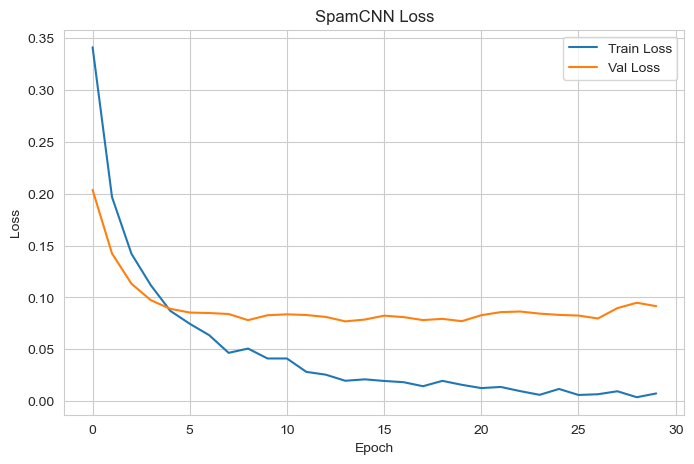

Metrics SpamCNN (best val acc):
      Metric     Value
0   Accuracy  0.989247
1  Precision  0.972603
2     Recall  0.946667
3         F1  0.959459


In [22]:
model1 = SpamCNN(vocab_size)
model1, train_losses1, val_losses1 = train_model_best_acc(model1, train_loader, val_loader, epochs=30, device=device)
metrics1 = evaluate_model(model1, test_loader, device)
plot_losses(train_losses1, val_losses1, title="SpamCNN Loss")
print("Metrics SpamCNN (best val acc):")
print(metrics1)

Epoch 1/30 | Train Loss: 0.3427 | Val Loss: 0.2309 | Val Acc: 0.9084
Epoch 2/30 | Train Loss: 0.1369 | Val Loss: 0.1071 | Val Acc: 0.9582
Epoch 3/30 | Train Loss: 0.0689 | Val Loss: 0.0888 | Val Acc: 0.9701
Epoch 4/30 | Train Loss: 0.0379 | Val Loss: 0.0912 | Val Acc: 0.9701
Epoch 5/30 | Train Loss: 0.0296 | Val Loss: 0.0866 | Val Acc: 0.9741
Epoch 6/30 | Train Loss: 0.0180 | Val Loss: 0.1101 | Val Acc: 0.9721
Epoch 7/30 | Train Loss: 0.0102 | Val Loss: 0.1585 | Val Acc: 0.9681
Epoch 8/30 | Train Loss: 0.0094 | Val Loss: 0.1132 | Val Acc: 0.9721
Epoch 9/30 | Train Loss: 0.0060 | Val Loss: 0.1201 | Val Acc: 0.9741
Epoch 10/30 | Train Loss: 0.0045 | Val Loss: 0.0940 | Val Acc: 0.9741
Epoch 11/30 | Train Loss: 0.0035 | Val Loss: 0.1296 | Val Acc: 0.9741
Epoch 12/30 | Train Loss: 0.0025 | Val Loss: 0.1442 | Val Acc: 0.9701
Epoch 13/30 | Train Loss: 0.0013 | Val Loss: 0.1394 | Val Acc: 0.9701
Epoch 14/30 | Train Loss: 0.0029 | Val Loss: 0.1574 | Val Acc: 0.9721
Epoch 15/30 | Train Loss: 0.0

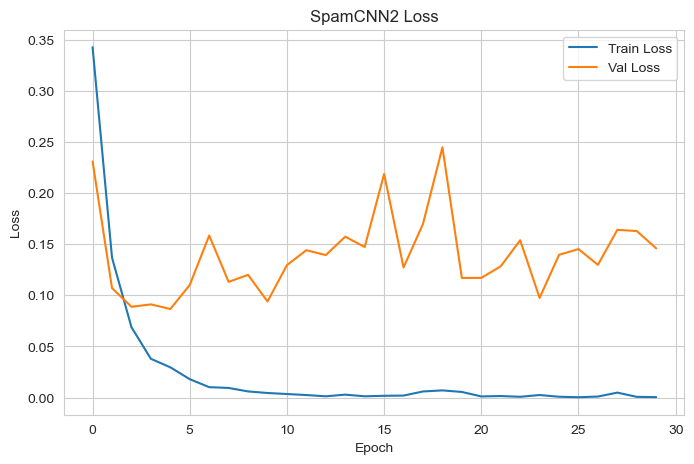

Metrics SpamCNN2 (best val acc):
      Metric     Value
0   Accuracy  0.987455
1  Precision  1.000000
2     Recall  0.906667
3         F1  0.951049


In [23]:
model2 = SpamCNN2(vocab_size)
model2, train_losses2, val_losses2 = train_model_best_acc(model2, train_loader, val_loader, epochs=30, device=device)
metrics2 = evaluate_model(model2, test_loader, device)
plot_losses(train_losses2, val_losses2, title="SpamCNN2 Loss")
print("Metrics SpamCNN2 (best val acc):")
print(metrics2)